# **<u>AutoML</u>**

**Class**: Northwestern IEMS 469 Fall 2025<br>
**Professor**: Diego Klabjan<br>
**Name**: Raymond Gu

### **Project Setup**
These are all the libraries used for this project. This code also creates 2 new folders:

* `Filtered Data`: A folder to store a filtered subset of the Federated EMNIST dataset.
* `Graphs`: A folder to store figures produced in this project.

In [1]:
# Import Libraries
import os
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Set the random seed
seed = 12345
random.seed(seed)
rng = np.random.RandomState(seed)

# Create folder for figures and filtered data
os.makedirs("Filtered Data", exist_ok=True)
os.makedirs("Graphs", exist_ok=True)

### **Processing & Formatting Data**

**Note**: Because the original dataset files were too large, they are in a ZIP file. To run this code, unzip the file such that `train_data.npy` and `test_data.npy` are both in the folder `Original Data`.<br>

The `Federated EMNIST` dataset consists of handwritten digits and letters from 100 users. There are 62 classes (10 digits, 26 lowercase, 26 uppercase) and each image is 28 by 28 pixels. For this project, we are only interested in the samples of digits only (10 classes).There are 2 functions used to filter and format the data.<br>

* `Filter_Data`: This function filters the training and test data to include on images of digits (labels 0-9). It saves training images + labels to `train_X.npy` and `train_Y.npy` (where X is images and Y is labels), and test images + labels to `test_X.npy` and `test_Y.npy` in the `Filtered Data` folder.

* `Format_Data`: This function preprocesses images (normalizing pixel values, reshaping, etc.) and splits training data into training and validation sets (80/20 split).

In [3]:
def filter_data():
    """
    **Purpose**
        Filters the training and test data to include only images of digits 
        (0-9). This function will save training images and labels to 
        train_X.npy and train_Y.npy, and test images and labels to
        test_X.npy and test_Y.npy in the 'Filtered Data' folder.
    """
    # Get the training and test data from the .npy files
    train_data = np.load(r'Original Data/train_data.npy', allow_pickle=True)
    test_data = np.load(r'Original Data/test_data.npy', allow_pickle=True)

    # Initialize lists to hold the filtered training data
    train_X = []
    train_Y = []

    # Loop through the clients
    for client_id in range(len(train_data)):
        
        # Extract the images and labels for the specified client
        client_train_images = np.array(train_data[client_id]['images'])
        client_train_labels = np.array(train_data[client_id]['labels'])

        # Filter the images and labels using the mask for digits 0-9
        train_mask = (client_train_labels >= 0) & (client_train_labels <= 9)
        filtered_client_train_images = client_train_images[train_mask]
        filtered_client_train_labels = client_train_labels[train_mask]

        # Append the filtered train data to the lists
        train_X.extend(filtered_client_train_images)
        train_Y.extend(filtered_client_train_labels)

    # Convert lists to numpy arrays
    train_X = np.array(train_X)
    train_Y = np.array(train_Y)
    
    # Get the test data
    test_images = np.array(test_data[0]['images'])
    test_labels = np.array(test_data[0]['labels'])

    # Create a mask for digits 0-9
    test_mask = (test_labels >= 0) & (test_labels <= 9)
    
    # Filter the images and labels using the mask
    filtered_test_images = test_images[test_mask]
    filtered_test_labels = test_labels[test_mask]

    # Append the filtered test data to the lists
    test_X = filtered_test_images
    test_Y = filtered_test_labels

    # Save the filtered data back to .npy files
    np.save(r'Filtered Data/train_X.npy', train_X)
    np.save(r'Filtered Data/train_Y.npy', train_Y)
    np.save(r'Filtered Data/test_X.npy', test_X)
    np.save(r'Filtered Data/test_Y.npy', test_Y)

def format_data():
    """
    **Purpose**
        Formats the training data by preprocessing images and splitting
        into training and validation sets. The default split ratio is 
        80% training and 20% validation. The functions returns the training,
        validation, and test datasets as PyTorch tensors.

    **Outputs**
        * train_X: PyTorch tensor of training images
        * train_Y: PyTorch tensor of training labels
        * valid_X: PyTorch tensor of validation images
        * valid_Y: PyTorch tensor of validation labels
        * test_X: PyTorch tensor of test images
        * test_Y: PyTorch tensor of test labels
    """
    # Load the training data from the .npy file
    train_X = np.load(r'Filtered Data/train_X.npy')
    train_Y = np.load(r'Filtered Data/train_Y.npy')

    # Load the test data from the .npy file
    test_X = np.load(r'Filtered Data/test_X.npy')
    test_Y = np.load(r'Filtered Data/test_Y.npy')

    # Normalize the pixel values for the images
    train_x = train_X.astype(np.float32) / 255.0
    test_x = test_X.astype(np.float32) / 255.0

    # Standardize (zero mean, unit variance)
    mean = train_X.mean()
    std = train_X.std()
    train_x = (train_x - mean) / (std + 1e-7)
    test_x = (test_x - mean) / (std + 1e-7)

    # Reshape the images
    train_X = train_X.reshape(-1, 1, 28, 28)
    test_X = test_X.reshape(-1, 1, 28, 28)

    # Split training data into training and validation sets
    train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, 
                                                          train_Y, 
                                                          test_size=0.2, 
                                                          random_state=42,
                                                          stratify=train_Y)
    
    # Convert to PyTorch tensors
    train_X = torch.FloatTensor(train_X)
    train_Y = torch.LongTensor(train_Y)
    valid_X = torch.FloatTensor(valid_X)
    valid_Y = torch.LongTensor(valid_Y)
    test_X = torch.FloatTensor(test_X)
    test_Y = torch.LongTensor(test_Y)

    return train_X, train_Y, valid_X, valid_Y, test_X, test_Y


### **Model Architecture & Training**

For this project, I decided to use a CNN. The architecture for the CNN classifier is shown below:

* **Convolutional Layers**: First, there are 2 convolutional layers (each followed by a pooling layer) used to build a latent representation.
    * **Resolution**: The resolution changes from 28x28 → 14x14 → 7x7.
    * **Channels**: The channels increase from 1 → 32 → 64.
    * **Activation Function**: The activation is configurable (ReLU, Tanh, or Sigmoid) and applied after each convoluational layer.

* **Fully Connected Layers**: After the convolutional layers, there are 2 fully connected layers.
    * **Nodes**: The number of nodes go from 3136 (64x7x7) → 128 → 10 (logits for each class).
    * **Activation Function**: The activation is configurable (ReLU, Tanh, or Sigmoid) and applied after layer 1.
    * **Dropout**: After the first fully connect layer, 25% of nodes are dropped to make the network more robust.

The model is trained by using stochastic gradient descent (SGD) with Nesterov momentum to help improve convergence stability. For the evaluation metric, I used maco-averaged F1 score.

In [4]:
class CNN(nn.Module):
    
    def __init__(self, activation_fn):
        super(CNN, self).__init__()

        # Define first convolutional layer
        self.conv_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool_1 = nn.MaxPool2d(2, 2)

        # Define second convolutional layer
        self.conv_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool_2 = nn.MaxPool2d(2, 2)

        # Define fully connected layers
        self.fc_1 = nn.Linear(64 * 7 * 7, 128)
        self.fc_2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

        # Decide activation function
        if activation_fn == 'relu':
            self.activation_fn = nn.ReLU()
        elif activation_fn == 'tanh':
            self.activation_fn = nn.Tanh()
        elif activation_fn == 'sigmoid':
            self.activation_fn = nn.Sigmoid()
        else:
            raise ValueError("Unsupported activation function.")
        
    def forward(self, x):
        
        # Push through convolutional layers
        x = self.pool_1(self.activation_fn(self.conv_1(x)))
        x = self.pool_2(self.activation_fn(self.conv_2(x)))

        # Flatten the tensor
        x = x.view(-1, 64 * 7 * 7)

        # Push through fully connected layers
        x = self.activation_fn(self.fc_1(x))
        x = self.dropout(x)
        x = self.fc_2(x)

        return x

def train_model(model, train_X, train_Y, valid_X, valid_Y, batch_size, learning_rate, num_epochs, device, track_metrics=False):
    """
    **Purpose**
        Trains the model using SGD and returns macro F1 scores per epoch.
    
    **Inputs**
        * model: The neural network model to be trained.
        * train_X: PyTorch tensor of training images.
        * train_Y: PyTorch tensor of training labels.
        * valid_X: PyTorch tensor of validation images.
        * valid_Y: PyTorch tensor of validation labels.
        * batch_size: Size of each training batch.
        * learning_rate: Learning rate for the optimizer.
        * num_epochs: Number of epochs to train the model.
        * device: The device to run the training on ('cpu' or 'cuda').

    **Outputs**
        * model: The trained neural network model.
        * train_f1_scores: List of F1 scores on training data per epoch.
        * valid_f1_score: F1 score on validation data after training.
    """
    # Move model to the specified device
    model = model.to(device)
    model.train()

    # Define optimizer and criterion with Nesterov momentum
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

    # Create batches for training data
    train_dataset = TensorDataset(train_X, train_Y)
    train_batches = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Store F1 scores per epoch
    train_f1_scores = []

    # Loop through each epoch
    for epoch in range(num_epochs):
        for batch_images, batch_labels in train_batches:

            # Move the data to the specified device
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # Compute the loss
            optimizer.zero_grad()
            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            loss.backward()

            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
        
        # Compute training F1 after this epoch
        if track_metrics:
            epoch_f1 = get_macro_f1_score(model, train_X, train_Y, batch_size, device)
            train_f1_scores.append(epoch_f1)

            # Set model back to training mode
            model.train()

    # Compute the final validation F1 score
    valid_f1_score = get_macro_f1_score(model, valid_X, valid_Y, batch_size, device)

    return model, train_f1_scores, valid_f1_score

def get_macro_f1_score(model, images, labels, batch_size, device):
    """
    **Purpose**
        Evaluates the model's macro-averaged F1 score on a given dataset.

    **Inputs**
        * model: The neural network model to be evaluated.
        * images: PyTorch tensor of images.
        * labels: PyTorch tensor of labels.
        * batch_size: Size of each evaluation batch.
        * device: The device to run the evaluation on ('cpu' or 'cuda').
    
    **Outputs**
        * f1: The F1 score of the model on the provided dataset.
    """
    # Set the model to evaluation mode
    model = model.to(device)
    model.eval()

    # Create batches for training data
    dataset = TensorDataset(images, labels)
    batches = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Initialize lists to hold true and predicted labels
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for batch_images, batch_labels in batches:

            # Move the data to the specified device
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # Get the model's predictins
            outputs = model(batch_images)
            predictions = outputs.argmax(dim=1)

            # Store the true and predicted labels
            all_true_labels.extend(batch_labels.cpu().numpy())
            all_predicted_labels.extend(predictions.cpu().numpy())

    # Convert lists to numpy arrays
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)

    # Calculate macro F1 score
    f1 = f1_score(all_true_labels, all_predicted_labels, average='macro')

    return f1


### **Genetic Algorithm**
I implement the Genetic Algorithm using the roulette rule, one-point crossover, and age based selection. Each individual in the population represents a candidate with a specific set of parameters for batch size and activation function. Here are some notes about my implementation of the Genetic Algorithm:

* **Fitness Metric**: Validation macro F1 score was used for each individual's fitness in the population.
* **Roulette Rule + Age Based Selection**: When selecting parents for the next generation, I used the roulette rule where individuals with higher adjusted fitness (validation macro F1 score penalized by age) are more likely to be chosen as parents.
* **One-Point Crossover**: Pairs of parents produce children through one-point crossover, which swaps batch size and activation function across the crossover point. After crossover, each child is mutated with a fixed probability by randomly changing either hyperparameter.
* **Generation Formation**: To form the next generation, the algorithm keeps the top half of the parent population and fills the remaining slots with children. This ensures both retention of strong performers and injection of new diversity.


In [5]:
def genetic_algorithm(train_X, train_Y, valid_X, valid_Y, num_generations, population_size, learning_rate, num_epochs, device):
    """
    **Purpose**
        Implements a genetic algorithm to optimize hyperparameters
        for training a neural network model.

    **Inputs**
        * train_X: PyTorch tensor of training images.
        * train_Y: PyTorch tensor of training labels.
        * valid_X: PyTorch tensor of validation images.
        * valid_Y: PyTorch tensor of validation labels.
        * num_generations: Number of generations to run the genetic algorithm.
        * population_size: Number of individuals in the population.
        * learning_rate: Learning rate for the optimizer.
        * num_epochs: Number of epochs to train each model.
        * device: The device to run the training on ('cpu' or 'cuda').
    """
    # Initialize the population with random individuals
    population = initialize_population(population_size)

    # Keep track of training statistics
    best_fitness_per_generation = []
    avg_fitness_per_generation = []

    # Loop through each generation
    for generation in range(num_generations):

        # Evaluate the population
        population = evaluate_population(population, train_X, train_Y, valid_X, valid_Y, learning_rate, num_epochs, device)

        # Track fitness
        fitness_values = [ind["fitness"] for ind in population]
        best_fitness = max(fitness_values)
        avg_fitness = np.mean(fitness_values)
        best_fitness_per_generation.append(best_fitness)
        avg_fitness_per_generation.append(avg_fitness)

        # Stop generating kids if last iteration
        if generation == num_generations - 1:
            break

        # Select parents based on fitness
        parents = select_parents(population)

        # Increment parent ages
        for parent in parents:
            parent['age'] += 1

        # Generate children through crossover
        children = generate_children(parents)

        # Form the next generation
        population = form_next_generation(parents, children, population_size)

    # Return the best individual from the final population
    best_individual = max(population, key=lambda ind: ind['fitness'])
    print(f"\nBest Individual: {best_individual}")

    return best_individual, best_fitness_per_generation, avg_fitness_per_generation

def form_next_generation(parents, children, population_size):
    """
    **Purpose**
        Forms the next generation by combining parents and children. The
        best half of the parents (based on fitness) are retained, and the
        children are mutated and shuffled before being added to fill the
        remaining slots in the next generation.

    **Inputs**
        * parents: List of parent individuals.
        * children: List of child individuals.
        * population_size: Number of individuals in the next generation.
    
    **Outputs**
        * next_generation: List of individuals for the next generation.
    """
    # Mutate and shuffle the children
    mutated_children = [mutate_child(child) for child in children]
    np.random.shuffle(mutated_children)

    # Sort parents by fitness
    parents = sorted(parents, key=lambda ind: ind['fitness'], reverse=True)
    elite_parents = parents[:population_size // 2]

    # Form the next generation (best parents + children)
    next_generation = elite_parents + mutated_children[:population_size - len(elite_parents)]

    return next_generation

def mutate_child(child, mutation_rate=0.1):
    """
    **Purpose**
        Mutates an individual by randomly changing its hyperparameters
        with a given mutation rate.

    **Inputs**
        * child: The individual to be mutated.
        * mutation_rate: Probability of mutating each hyperparameter.

    **Outputs**
        * child: The mutated individual.
    """
    # Mutate batch_size with probability of mutation_rate
    if np.random.rand() < mutation_rate:
        child['batch_size'] = int(2 ** np.random.randint(4, 11))

    # Mutate activation_fn with probability of mutation_rate
    if np.random.rand() < mutation_rate:
        possible_activations = ['relu', 'sigmoid', 'tanh']
        possible_activations.remove(child['activation_fn'])
        child['activation_fn'] = random.choice(possible_activations)

    return child

def generate_children(parents):
    """
    **Purpose**
        Generates children individuals by performing one-point
        crossover with parent individuals.

    **Inputs**
        * parents: List of parent individuals.
    """
    # Create list to store children generated
    children = []

    # Shuffle parents to ensure randomness
    np.random.shuffle(parents)
    num_parents = len(parents)

    # Loop through pairs of parents to create children
    for i in range(0, num_parents, 2):

        # Get the 2 parents (wrap around if odd number of parents)
        parent_1 = parents[i]
        parent_2 = parents[(i + 1) % num_parents]

        # Select the crossover point (between 1 and 2)
        crossover_point = np.random.randint(1, 2)

        # Create children by swapping batch_size
        if crossover_point == 1:
            child_1 = {"batch_size": parent_1['batch_size'],
                       "activation_fn": parent_2['activation_fn'],
                       "age": 0}
            
            child_2 = {"batch_size": parent_2['batch_size'],
                       "activation_fn": parent_1['activation_fn'],
                       "age": 0}
        
        # Create children by copying parents    
        else:
            child_1 = parent_1.copy()
            child_1['age'] = 0
            
            child_2 = parent_2.copy()
            child_2['age'] = 0

        # Append children to the list
        children.append(child_1)
        children.append(child_2)

    return children

def select_parents(population):
    """
    **Purpose**
        Selects the top individuals from the population based on their
        validation F1 scores.

    **Inputs**
        * population: List of individuals with validation F1 scores.

    **Outputs**
        * selected_parents: List of samples parents (based on fitness scores).
    """
    # Compute adjusted fitness (penalize older individuals)
    adjusted_fitnesses = ([ind['fitness'] / (ind['age'] + 1) for ind in population])
    adjusted_fitnesses = np.array(adjusted_fitnesses)
    
    # Convert fitness to selection probabilities
    total_fitness = np.sum(adjusted_fitnesses)
    probabilities = adjusted_fitnesses / total_fitness

    # Select parents based on probabilities
    pop_size = len(population)
    selected_indices = np.random.choice(pop_size, size=pop_size, p=probabilities, replace=False)
    selected_parents = [population[i].copy() for i in selected_indices]

    return selected_parents

def evaluate_population(population, train_X, train_Y, valid_X, valid_Y, learning_rate, num_epochs, device):
    """
    **Purpose**
        Evaluates each individual in the population by training a model
        with their hyperparameters and computing the validation F1 score.

    **Inputs**
        * population: List of individuals with hyperparameters.
        * train_X: PyTorch tensor of training images.
        * train_Y: PyTorch tensor of training labels.
        * valid_X: PyTorch tensor of validation images.
        * valid_Y: PyTorch tensor of validation labels.
        * learning_rate: Learning rate for the optimizer.
        * num_epochs: Number of epochs to train each model.
        * device: The device to run the training on ('cpu' or 'cuda').

    **Outputs**
        * population: List of individuals with added validation F1 scores.
    """
    # Loop through each individual in the population
    for individual in population:

        # Create a model with the individual's hyperparameters
        model = CNN(individual['activation_fn'])

        # Train the model and get the validation F1 score
        _, _, valid_f1_score = train_model(model, train_X, train_Y, 
                                           valid_X, valid_Y, individual['batch_size'],
                                           learning_rate, num_epochs, device)

        # Add the validation F1 score to the individual
        individual['fitness'] = valid_f1_score

    return population

def initialize_population(population_size):
    """
    **Purpose**
        Initializes a population of individuals with random hyperparameters.
        The batch size will be chosen as powers of 2 between 16 and 1024. The
        activation function will be randomly selected from 'relu', 'sigmoid',
        and 'tanh'. The age of each individual is initialized to 0.

    **Inputs**
        * population_size: Number of individuals in the population.

    **Outputs**
        * population: List of individuals with random hyperparameters.
    """
    # Create an empty population list
    population = []
    for _ in range(population_size):

        # Create an individual with random hyperparameters
        individual = {"batch_size": int(2 ** np.random.randint(4, 11)),
                      "activation_fn": random.choice(['relu', 'sigmoid', 'tanh']),
                      "age": 0}
        
        # Append the individual to the population
        population.append(individual)

    return population

def graph_generation_history(filepath, best_history, avg_history):
    
    # Plot the generation history
    plt.title(f'Validation F1 Score over Generations')
    plt.plot(best_history, label="Best Fitness")
    plt.plot(avg_history, label="Average Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Validation F1")
    plt.legend()

    # Save and show the figure
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

def graph_best_parameters(filepath, train_f1_scores, test_f1_score):
    
    # Plot the training F1 scores over epochs
    plt.title(f'Training F1 Score over Epochs')
    plt.plot(train_f1_scores, label="Training F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("Training F1 Score")
    plt.legend()

    plt.figtext(
        0.5, -0.05,
        f"Final Test F1 Score: {test_f1_score:.4f}",
        ha="center", fontsize=12
    )

    # Save and show the figure
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()


#### | **Genetic Algorithm Results**
The code below shows the results of using the Genetic Algorithm on the filtered subset of the Federated EMNIST dataset. The graph shows the average and highest fitness score of the population every generation.


Best Individual: {'batch_size': 64, 'activation_fn': 'tanh', 'age': 0, 'fitness': 0.9888255182717925}


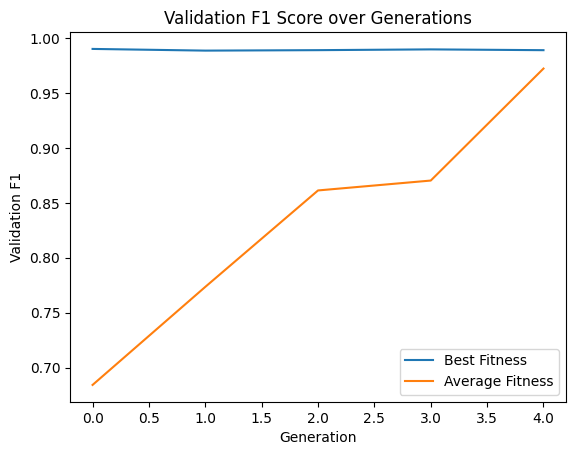

In [7]:
def run_genetic_algorithm(num_generations, population_size, learning_rate, num_epochs):
    
    # Filter the data to include only digits
    filter_data()

    # Format the training data
    train_X, train_Y, valid_X, valid_Y, _, _ = format_data()
    
    # Determine the device to run on
    device = torch.device('cuda' if torch.cuda.is_available() else ValueError("No GPU available"))

    # Run the genetic algorithm
    best, best_history, avg_history = genetic_algorithm(train_X, train_Y, valid_X, valid_Y, num_generations, population_size, learning_rate, num_epochs, device)

    # Graph the generation history
    filepath = os.path.join("Graphs", "genetic_algorithm_history.png")
    graph_generation_history(filepath, best_history, avg_history)

    return best

best_individual = run_genetic_algorithm(num_generations=5, population_size=10, learning_rate=0.05, num_epochs=10)

#### | **Testing Best Hyperparameters**
The code below trains a model using the best hyperparameters found from the Genetic Algorithm. The graph shows the training macro F1 score every epoch and displays the test macro F1 score at the end of training.

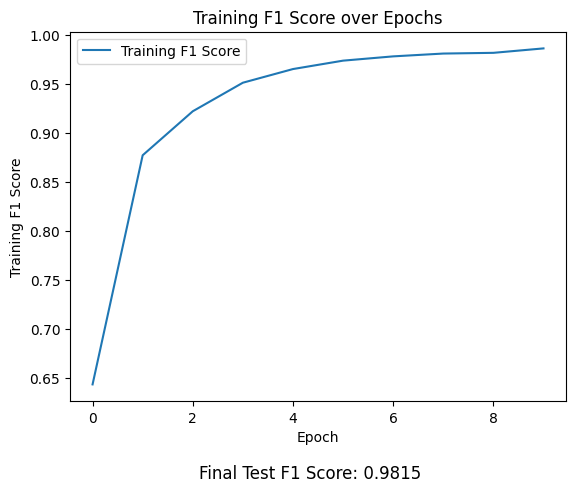

In [10]:
def use_best_parameters(activation_fn, batch_size):
    
    # Filter the data to include only digits
    filter_data()

    # Format the training data
    train_X, train_Y, valid_X, valid_Y, test_X, test_Y = format_data()

    # Determine the device to run on
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create model and train it
    model = CNN(activation_fn)
    model, train_f1_scores, valid_f1_score = train_model(model, train_X, train_Y, valid_X, valid_Y, batch_size, 0.01, 10, device, track_metrics=True)
    test_f1_score = get_macro_f1_score(model, test_X, test_Y, batch_size, device)

    # Graph results
    filepath = os.path.join("Graphs", "genetic_algorithm_best_parameters.png")
    graph_best_parameters(filepath, train_f1_scores, test_f1_score)

use_best_parameters(activation_fn='tanh', batch_size=64)